In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.append(os.path.abspath('../..'))

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from text_recognizer.models.line_detector_model import LineDetectorModel
from text_recognizer.datasets.iam_paragraphs import IamParagraphsDataset

import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%time

dataset = IamParagraphsDataset(image_shape=(256, 256))
dataset.load_or_generate_data()
print(dataset)

Max crop width and height were found to be 1240x1156.
Setting them to 1240x1240
Cropping paragraphs, generating ground truth, and saving debugging images to /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/interim/iam_paragraphs/debug_crops
Rescued /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/raw/iam/iamdb/forms/e01-081.jpg: could not broadcast input array from shape (587,1236) into shape (587,1240)
Rescued /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/raw/iam/iamdb/forms/e01-086.jpg: could not broadcast input array from shape (687,1236) into shape (687,1240)
Loading IAM paragraph crops and ground truth from image files...
IAM Paragraphs Dataset
Num classes: 3
Train: (1229, 256, 256) (1229, 256, 256, 3)
Test: (308, 256, 256) (308, 256, 256, 3)

CPU times: user 26.1 s, sys: 5.7 s, total: 31.8 s
Wall time: 32.1 s


In [3]:
K.clear_session()
model = LineDetectorModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 800         reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
base_model_dirname = './_models'
!mkdir -p {base_model_dirname}

identifier = utils.generate_unique_identifier(dirname_with_identifiers=base_model_dirname)

model_dirname = f'{base_model_dirname}/{identifier}'
checkpoints_dirname = f'{model_dirname}/_checkpoints'

!mkdir -p {model_dirname}
!mkdir -p {checkpoints_dirname}

model_dirname

'./_models/juhnhcfq'

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=35),
    ModelCheckpoint(
            filepath=checkpoints_dirname + "/epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5",
            monitor='val_loss',
            save_best_only=True
        )
]

model.fit(dataset=dataset, batch_size=32, epochs=1000, augment_val=False, callbacks=callbacks)

Epoch 1/1000
39/39 [==============================] - 37s 944ms/step - loss: 23.4944 - val_loss: 15.1096
Epoch 2/1000
39/39 [==============================] - 32s 825ms/step - loss: 14.2739 - val_loss: 12.2555
Epoch 3/1000
39/39 [==============================] - 33s 845ms/step - loss: 12.3153 - val_loss: 10.8667
Epoch 4/1000
39/39 [==============================] - 33s 838ms/step - loss: 11.0564 - val_loss: 10.1245
Epoch 5/1000
39/39 [==============================] - 33s 849ms/step - loss: 9.4410 - val_loss: 7.8801
Epoch 6/1000
39/39 [==============================] - 33s 839ms/step - loss: 7.9481 - val_loss: 7.8598
Epoch 7/1000
39/39 [==============================] - 32s 825ms/step - loss: 7.0353 - val_loss: 7.0097
Epoch 8/1000
39/39 [==============================] - 33s 856ms/step - loss: 6.2969 - val_loss: 5.9441
Epoch 9/1000
39/39 [==============================] - 32s 828ms/step - loss: 5.8666 - val_loss: 5.2298
Epoch 10/1000
39/39 [==============================] - 33s 835ms/

In [28]:
# model.load_weights()
model.network.load_weights('models/alternating_line_detection_model_256x256.h5')

In [29]:
model.evaluate(dataset.x_test, dataset.y_test, batch_size=32)

308/308 [==============================] - 3s 9ms/step


3.5742687002404945

In [32]:
model.save_weights()

In [20]:
def plot(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap='gray', vmin=0, vmax=max(1, image.max()))
    plt.colorbar()

def hplot(x, y, y_pred=None, title=''):
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(title)
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(x, cmap='gray', vmin=0, vmax=max(1, x.max()))
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(y, cmap='gray', vmin=0, vmax=max(1, y.max()))
    
    if y_pred is not None:
        ax3 = fig.add_subplot(133)
        ax3.imshow(y_pred, cmap='gray', vmin=0, vmax=max(1, y_pred.max()))

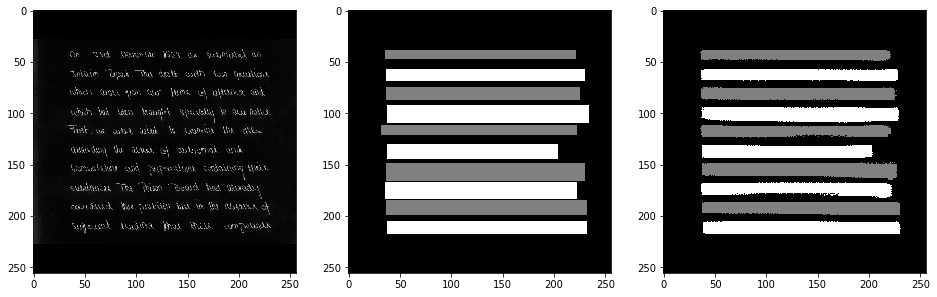

In [30]:
y_pred = model.predict_on_image(dataset.x_test[0])
hplot(dataset.x_test[0], dataset.y_test[0].argmax(axis=-1), y_pred.argmax(axis=-1))

In [11]:
model.network.load_weights('models/alternating_line_detection_model_256x256.h5')

In [13]:
model.save_weights()

In [14]:
model.load_weights()

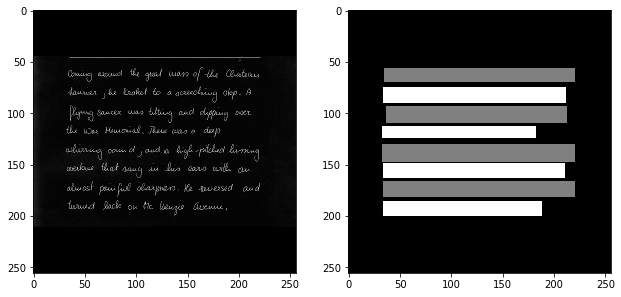

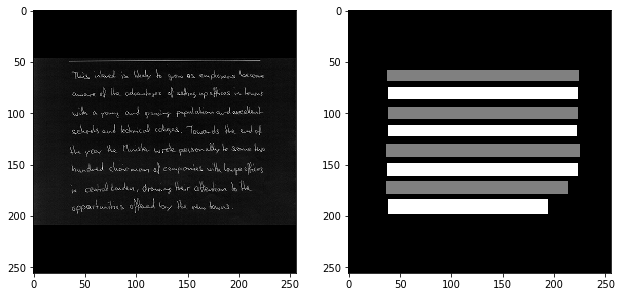

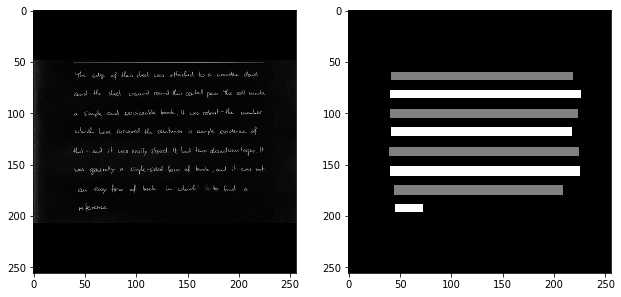

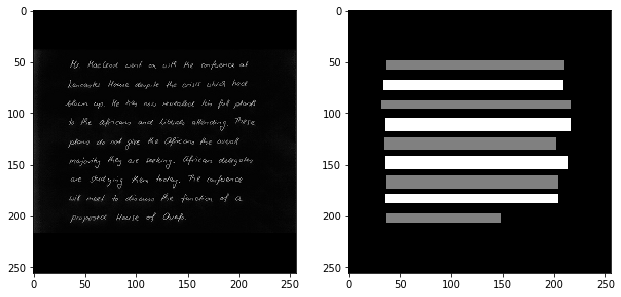

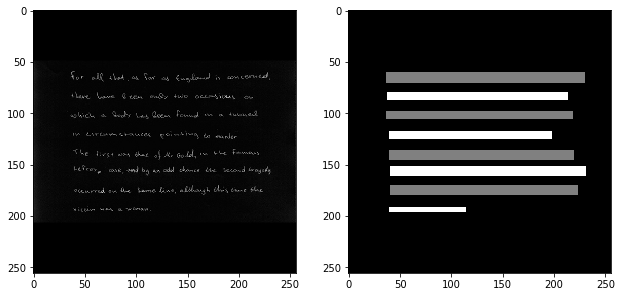

In [4]:
num_plot = 5

for i in np.random.randint(0, dataset.x_train.shape[0], num_plot):
    hplot(dataset.x_train[i], np.argmax(dataset.y_train[i], axis=-1))

In [5]:
MAX_HEIGHT, MAX_WIDTH = dataset.x_train.shape[1:-1]
MAX_HEIGHT, MAX_WIDTH

(256, 256)

In [6]:
base_model_dirname = './_models'
!mkdir -p {base_model_dirname}

identifier = utils.generate_unique_identifier(dirname_with_identifiers=base_model_dirname)

model_dirname = f'{base_model_dirname}/{identifier}'
checkpoints_dirname = f'{model_dirname}/_checkpoints'

!mkdir -p {model_dirname}
!mkdir -p {checkpoints_dirname}

model_dirname

'./_models/5apj4luj'

In [7]:
from typing import Tuple
from tensorflow.keras.utils import Sequence
# import .data_augmentations as augmentations

data_augmentation_params = {
    'width_shift_range': 0.06,
    'height_shift_range': 0.1,
    'horizontal_flip': True,
    'zoom_range': 0.1,
    'fill_mode': 'constant',
    'cval': 0,
    'shear_range': 3,
#     'rotation_range': 2,
#     'vertical_flip': True, - this is a problem for even number of lines.
}


# def random_intensity_transformations(image: np.ndarray) -> np.ndarray:
#     """Randomly apply one of the image intensity transformations on the image."""
#     transformation_functions = [
#         augmentations.noop,
#         augmentations.random_intensity_stretch,
#         augmentations.random_intensity_shrink,
#         augmentations.random_adaptive_histogram_equalization,
#         augmentations.random_gamma_correction,
#         augmentations.random_logarithmic_correction,
#         augmentations.sigmoid_correction,
#     ]
#     function = np.random.choice(transformation_functions)
#     return function(image).astype('float32')


def shuffle(X, Y):
    shuffled_indices = np.random.permutation(X.shape[0])
    return X[shuffled_indices], Y[shuffled_indices]


class DataGenerator(Sequence):
    def __init__(self, X: np.ndarray, Y: np.ndarray, batch_size:int, augment: bool, verbose: bool=False):
        assert X.shape[:-1] == Y.shape[:-1]
        if X.ndim == 4:
            self.X = X
            self.Y = Y
        elif X.ndim == 3:
            self.X = np.expand_dims(X, axis=-1)
            self.Y = np.expand_dims(Y, axis=-1)
        else:
            assert False
        self.batch_size = batch_size
        self.augment = augment
        self.verbose = verbose
        self.num_batches = int(np.ceil(len(X) / self.batch_size))
        self.data_augmentor = ImageDataGenerator(**data_augmentation_params)

    def __log__(self, text: str) -> None:
        if self.verbose:
            print(text)

    def __len__(self) -> int:
        self.__log__(f'Number of batches: {self.num_batches}')
        return self.num_batches

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        self.__log__(f'Enter __getitem__() idx: {idx}')
        X_batch = self.X[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        Y_batch = self.Y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        if self.augment:
            X_batch, Y_batch = self.augment_data(X_batch, Y_batch)
            X_batch, Y_batch = shuffle(X_batch, Y_batch)
            assert len(np.unique(Y_batch)) == 2

        self.__log__(f'Exit __getitem__() idx: {idx}, X: {X_batch.shape}, Y: {Y_batch.shape}')
        return X_batch, Y_batch

    def augment_data(self, X, Y):
        X_aug, Y_aug = zip(*[self._augment_data(x, y) for x, y in zip(X, Y)])
        return np.stack(X_aug, axis=0), np.stack(Y_aug, axis=0)

    def _augment_data(self, x, y):
        transform_parameters = self.data_augmentor.get_random_transform(x.shape)
        x_aug = self.data_augmentor.apply_transform(x, transform_parameters)
        y_aug = self.data_augmentor.apply_transform(y, transform_parameters)
#         x_aug = random_intensity_transformations(x_aug)
        return x_aug, y_aug
    
    def on_epoch_end(self) -> None:
        """
        Shuffle all submissions in the dataframe so that the model does not see the same set of submissions
        (shuffled or not) in a step of any epoch.
        """
        self.X, self.Y = shuffle(self.X, self.Y)

### Test data generator

In [8]:
train_dg = DataGenerator(X=dataset.x_train, Y=dataset.y_train, batch_size=5, augment=True)
train_dg.__len__()

246

In [9]:
X, Y = train_dg.__getitem__(3)
X.shape, Y.shape

((5, 256, 256, 1), (5, 256, 256, 3))

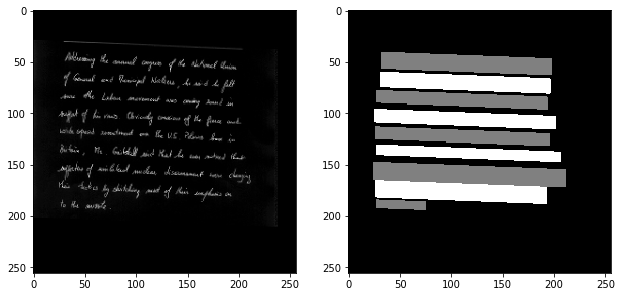

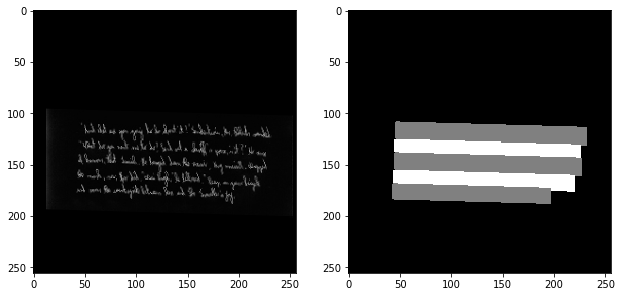

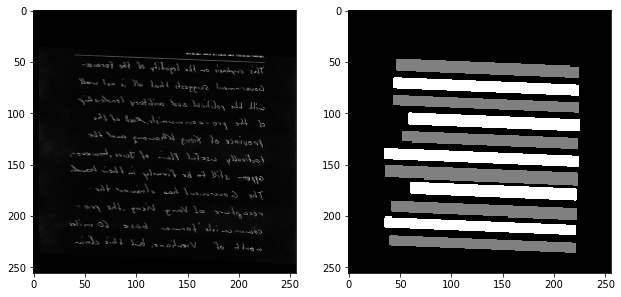

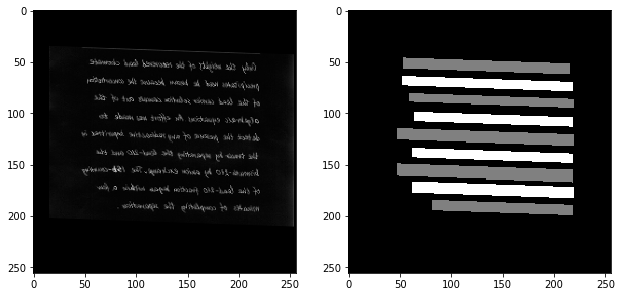

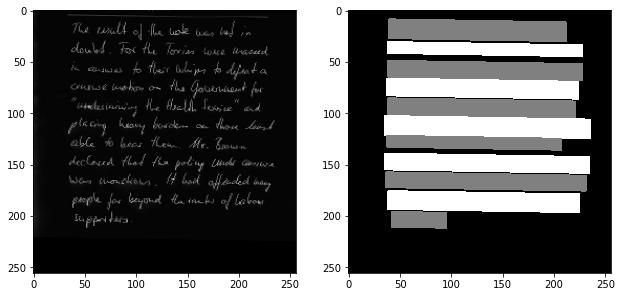

In [10]:
for i in range(5):
    hplot(X[i], np.argmax(Y[i], axis=-1))

## Model

In [14]:
from typing import List

K.clear_session()  

def residual_conv_block(input_layer: Layer,
                        kernel_sizes: List[int],
                        num_filters: List[int],
                        dilation_rates: List[int],
                        act: str) -> Layer:
    """Method to instantiate a Residual convolutional block."""
    assert len(num_filters) == 2

    padding = 'same'
    x = Conv2D(num_filters[0], kernel_size=kernel_sizes[0], dilation_rate=dilation_rates[0], 
               padding=padding, activation=act)(input_layer)
    x = Conv2D(num_filters[1], kernel_size=kernel_sizes[1], dilation_rate=dilation_rates[1], padding=padding)(x)
    y = Conv2D(num_filters[1], kernel_size=1, dilation_rate=1, padding=padding)(input_layer)
    x = Add()([x, y])
    x = Activation(act)(x)
    return x

num_filters = [16] * 14
kernel_sizes = [7] * 14
dilation_rates = [3] * 4 + [7] * 10

input_image = Input((MAX_HEIGHT, MAX_WIDTH, 1))

model_layer = input_image
for i in range(0, len(num_filters), 2):
    model_layer = residual_conv_block(input_layer=model_layer, 
                                      kernel_sizes=kernel_sizes[i:i+2], 
                                      num_filters=num_filters[i:i+2], 
                                      dilation_rates=dilation_rates[i:i+2], 
                                      act='relu')
output = Conv2D(dataset.num_classes, kernel_size=1, dilation_rate=1, padding='same', activation='softmax')(model_layer)

model = Model(inputs=input_image, outputs=output)
model.compile(optimizer=Adam(0.001/2), loss='categorical_crossentropy')    
model.summary()

    
callbacks = [
    EarlyStopping(monitor='val_loss', patience=35),
    ModelCheckpoint(
            filepath=checkpoints_dirname + "/epoch_{epoch:02d}-val_loss_{val_loss:.4f}.h5",
            monitor='val_loss',
            save_best_only=True
        )
]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 800         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
add (Add) 

In [15]:
%%time 

batch_size = 32
train_dg = DataGenerator(X=dataset.x_train, Y=dataset.y_train, batch_size=batch_size, augment=True)

history = model.fit_generator(
    generator=train_dg, 
    epochs=1000,
    validation_data=(dataset.x_test, dataset.y_test),
    shuffle=True,
    callbacks=callbacks    
)

Epoch 1/1000
39/39 [==============================] - 35s 887ms/step - loss: 22.7099 - val_loss: 15.6361
Epoch 2/1000
39/39 [==============================] - 32s 820ms/step - loss: 15.5553 - val_loss: 13.9937
Epoch 3/1000
39/39 [==============================] - 32s 826ms/step - loss: 14.3950 - val_loss: 12.8460
Epoch 4/1000
39/39 [==============================] - 32s 832ms/step - loss: 13.2623 - val_loss: 11.5656
Epoch 5/1000
39/39 [==============================] - 33s 838ms/step - loss: 11.0028 - val_loss: 8.2486
Epoch 6/1000
39/39 [==============================] - 33s 838ms/step - loss: 8.6243 - val_loss: 8.2744
Epoch 7/1000
39/39 [==============================] - 33s 840ms/step - loss: 7.1836 - val_loss: 6.8938
Epoch 8/1000
39/39 [==============================] - 33s 839ms/step - loss: 6.7515 - val_loss: 6.8069
Epoch 9/1000
39/39 [==============================] - 33s 844ms/step - loss: 6.5973 - val_loss: 6.1652
Epoch 10/1000
39/39 [==============================] - 33s 837ms

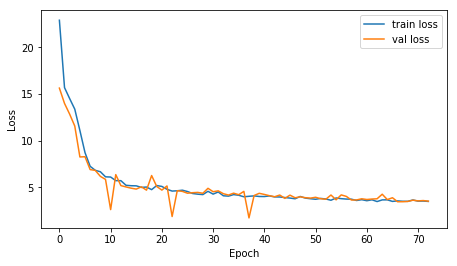

In [16]:
utils.plot_training_history(history.history, metric=None)

## Loading best model

In [17]:
model_filenames = !ls {checkpoints_dirname} -t
best_model_filename = model_filenames[0]

!cp {checkpoints_dirname}/{best_model_filename} {model_dirname}
!rm {checkpoints_dirname}/*
best_model_filename

'epoch_38-val_loss_1.7063.h5'

In [18]:
model.load_weights(f'{model_dirname}/{best_model_filename}')
best_model_filename

'epoch_38-val_loss_1.7063.h5'

## Model evaluation

In [20]:
model.evaluate(dataset.x_test, dataset.y_test, batch_size=batch_size)

308/308 [==============================] - 3s 9ms/step


4.1448325832168775

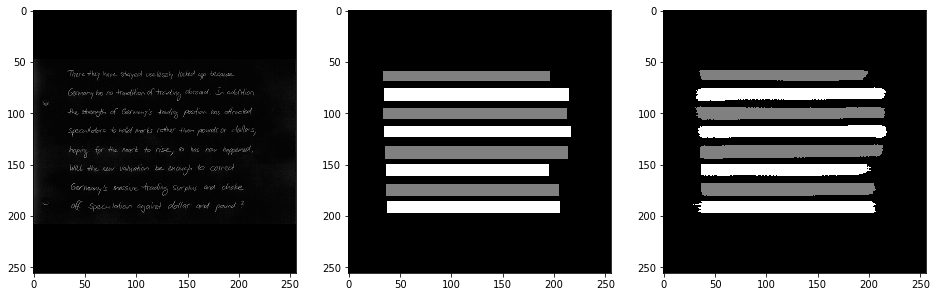

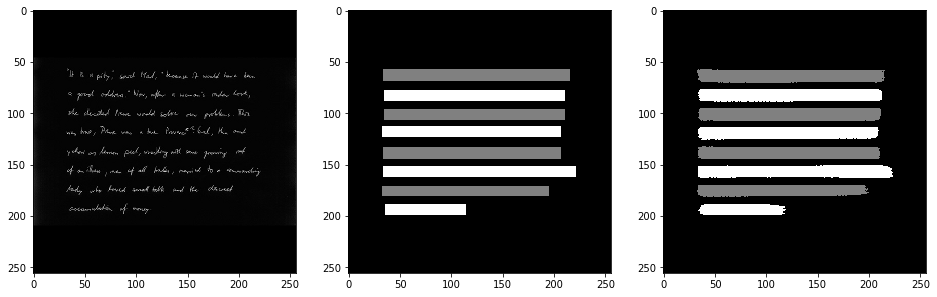

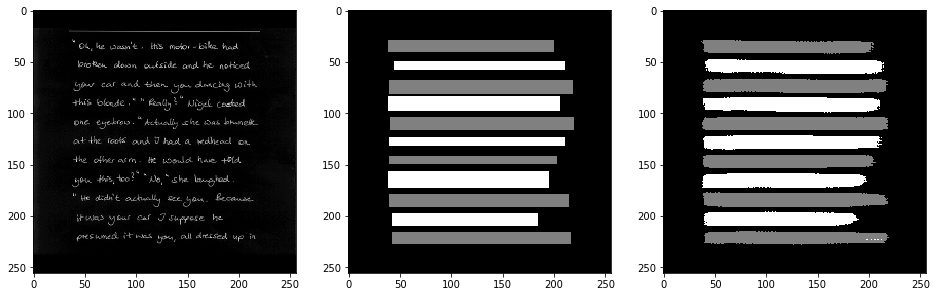

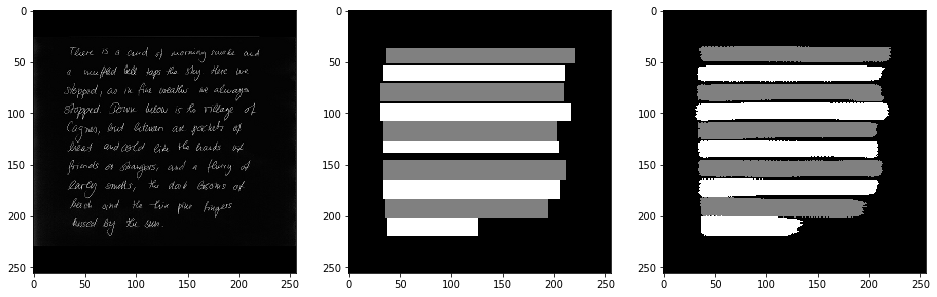

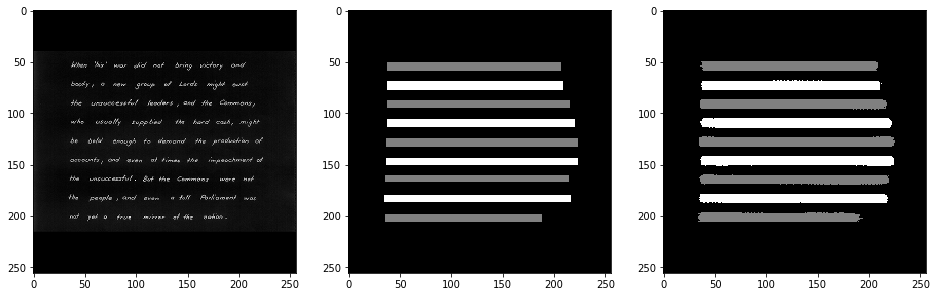

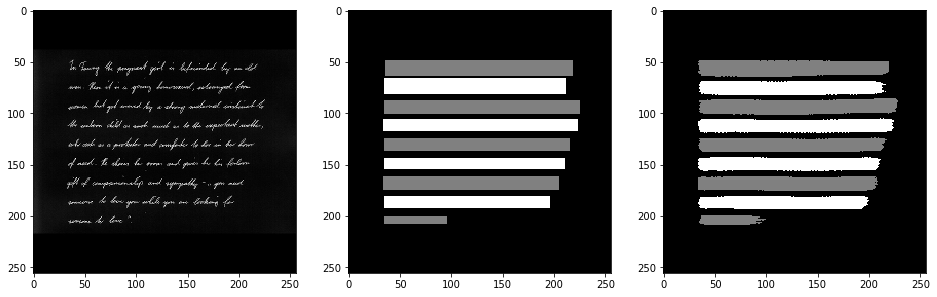

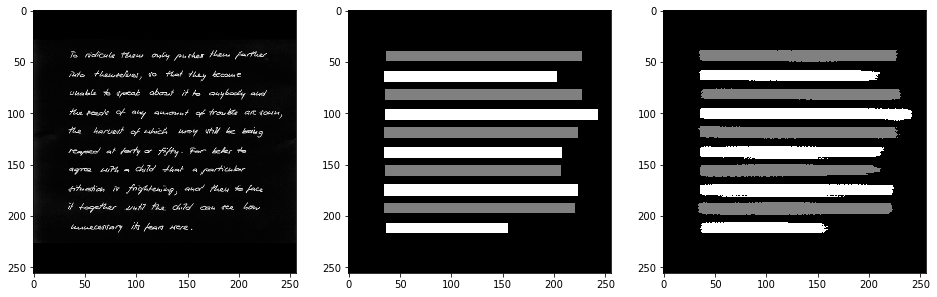

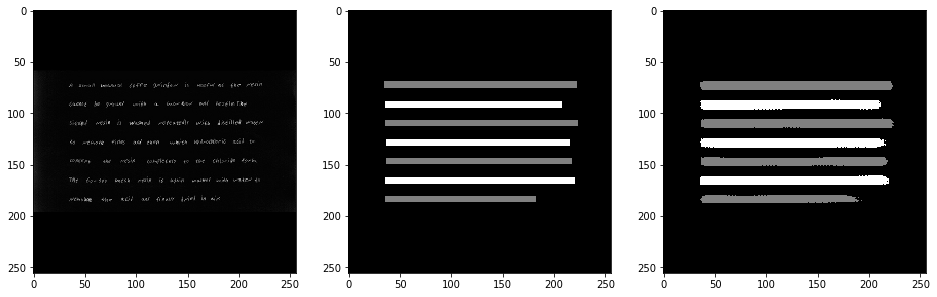

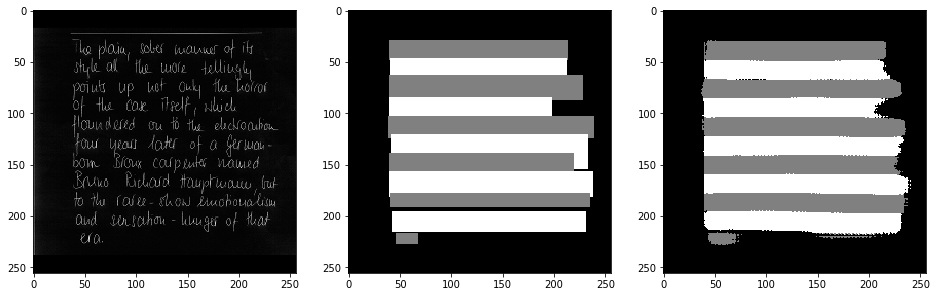

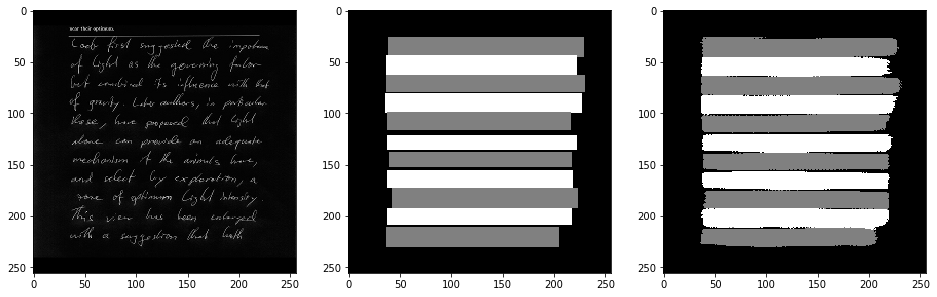

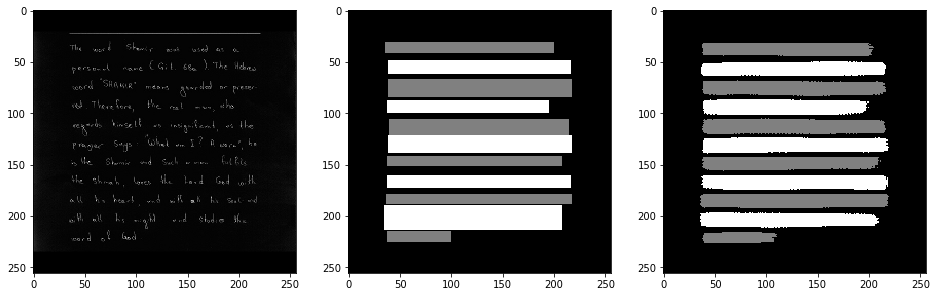

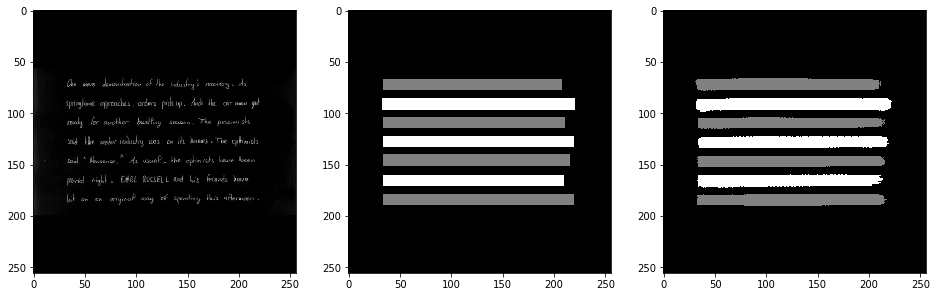

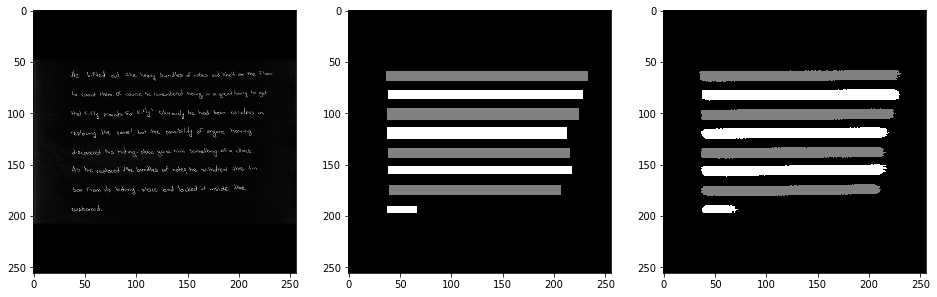

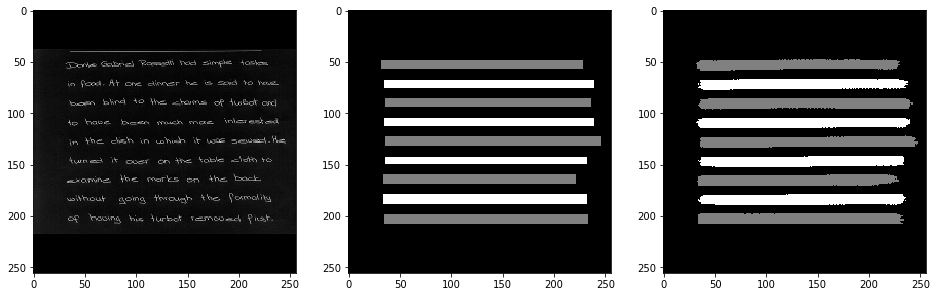

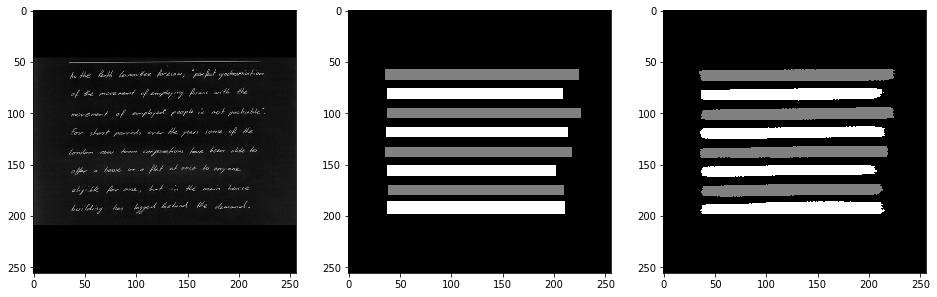

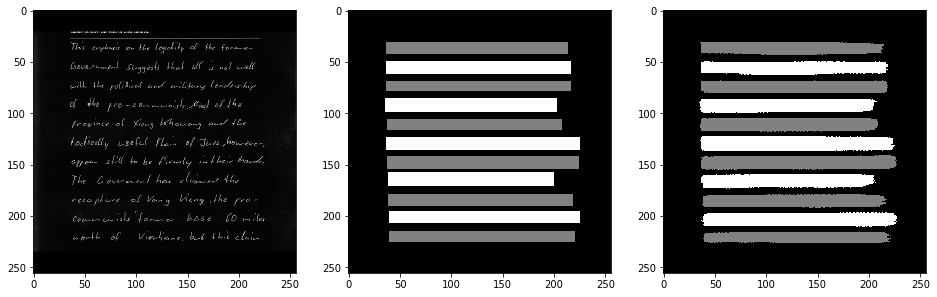

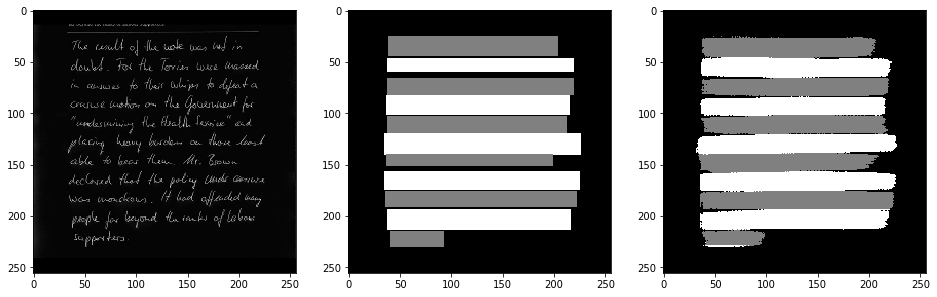

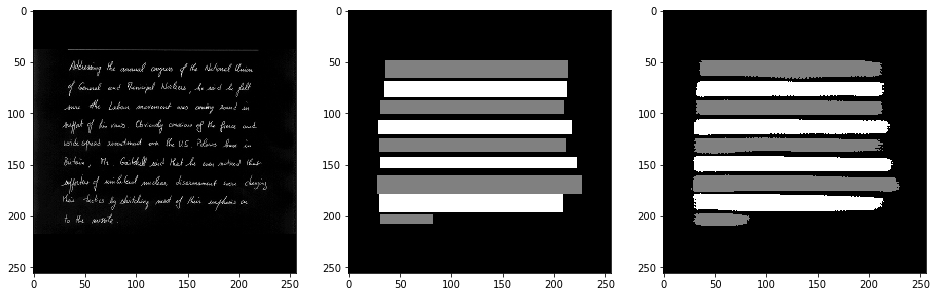

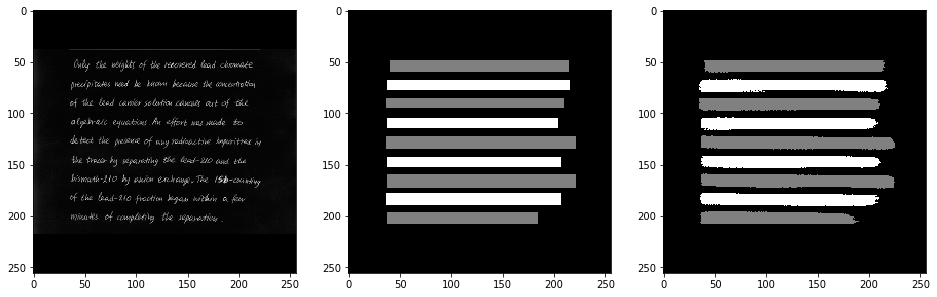

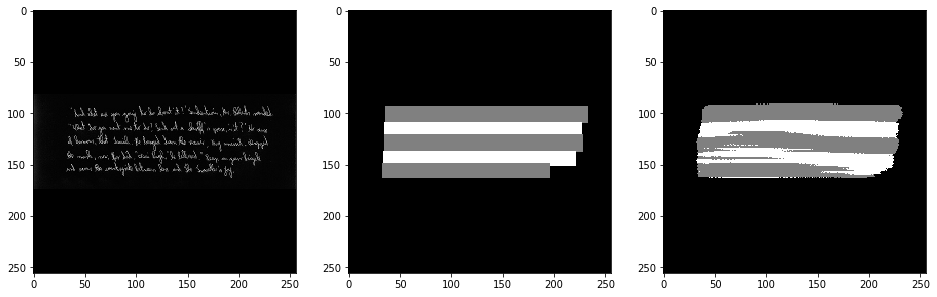

In [21]:
start_id = 0
count = 20

X = dataset.x_train[start_id:start_id+count]
Y = dataset.y_train[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))

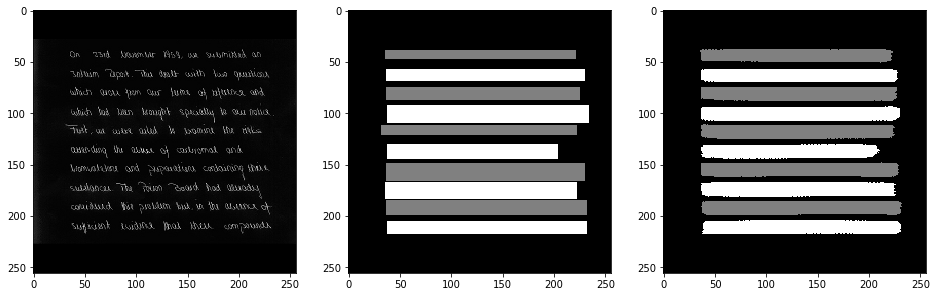

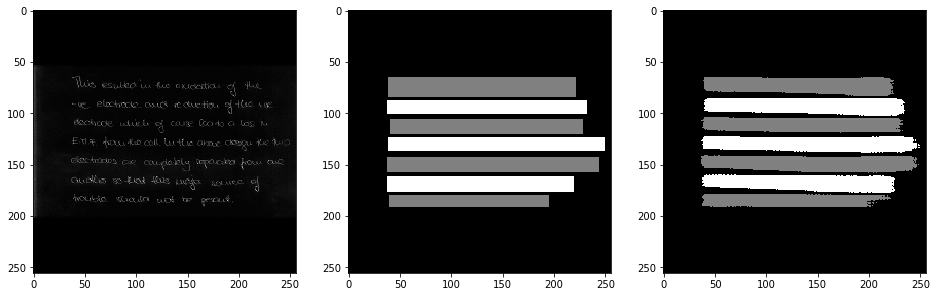

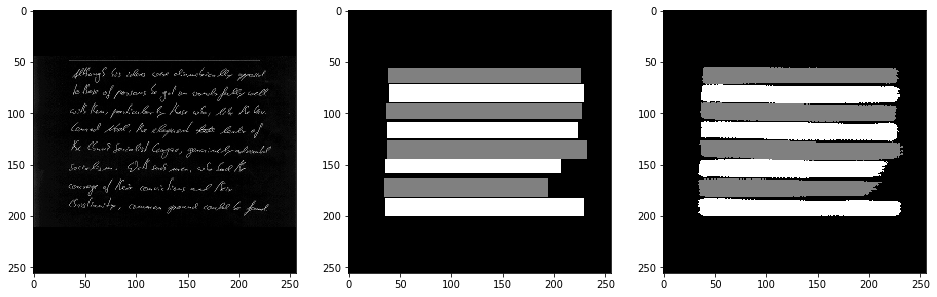

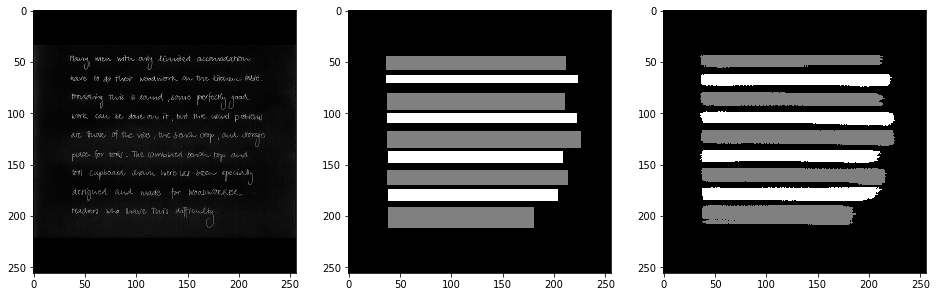

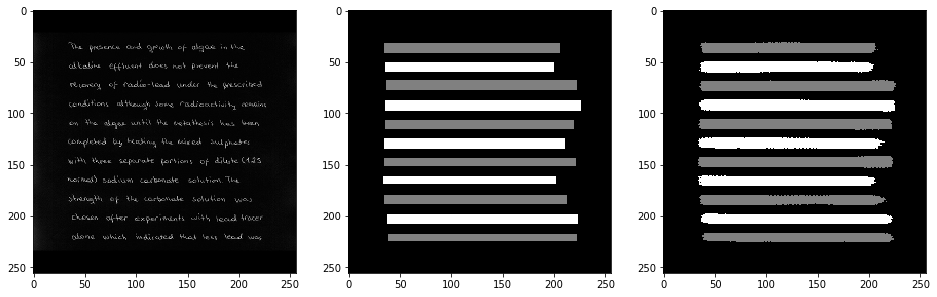

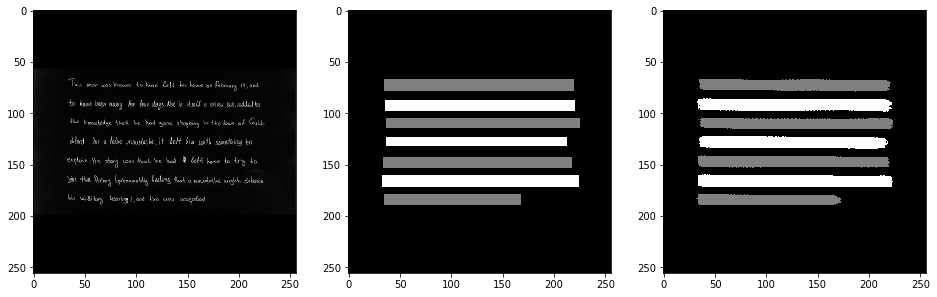

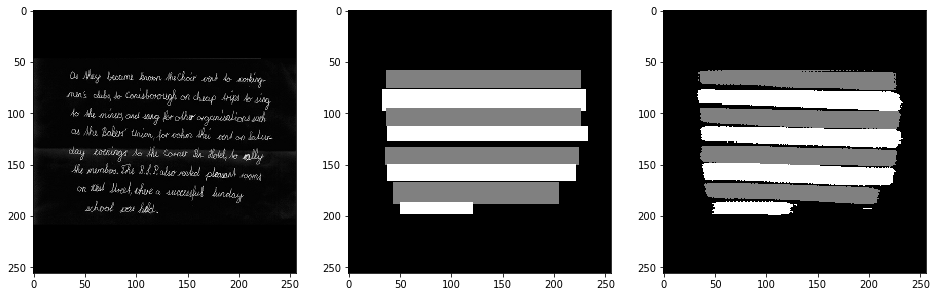

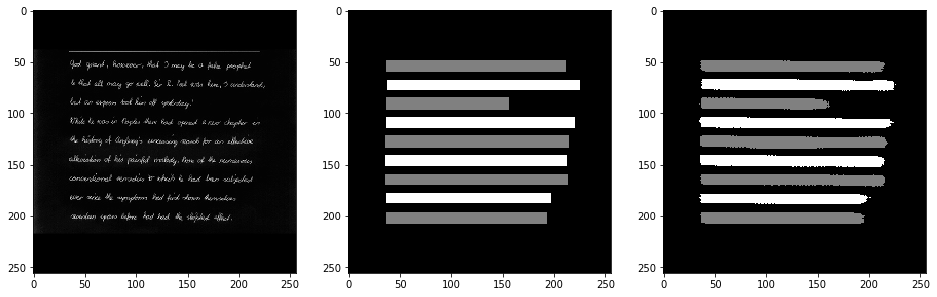

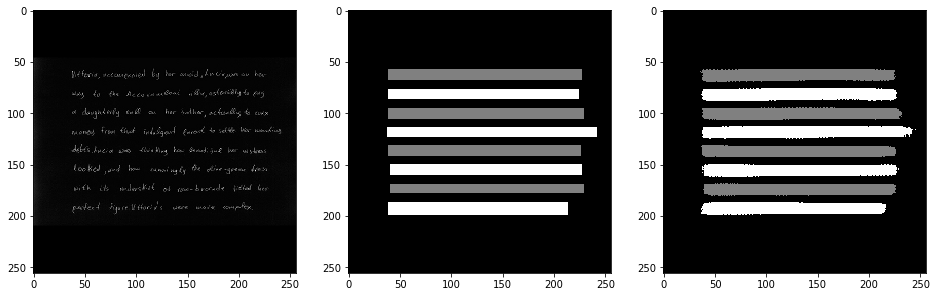

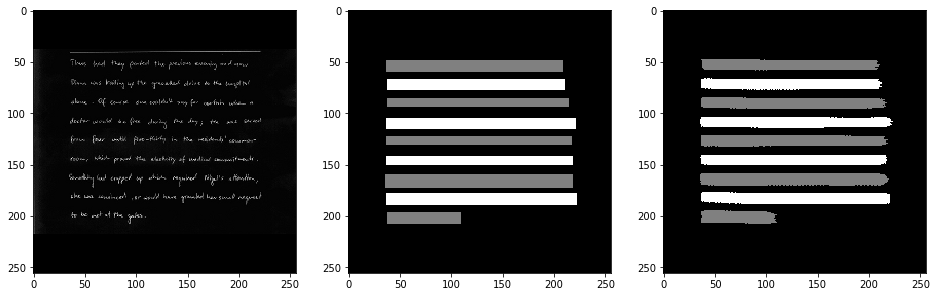

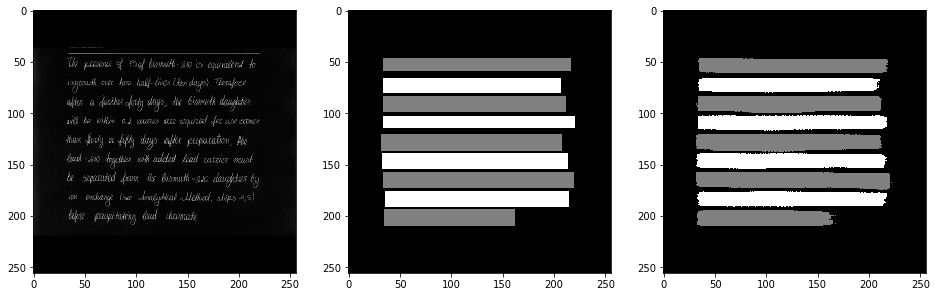

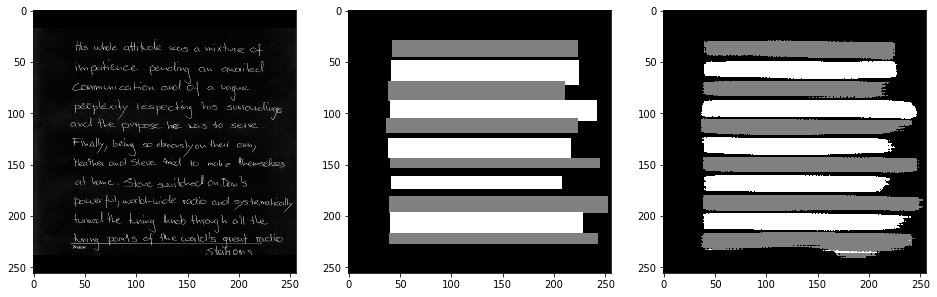

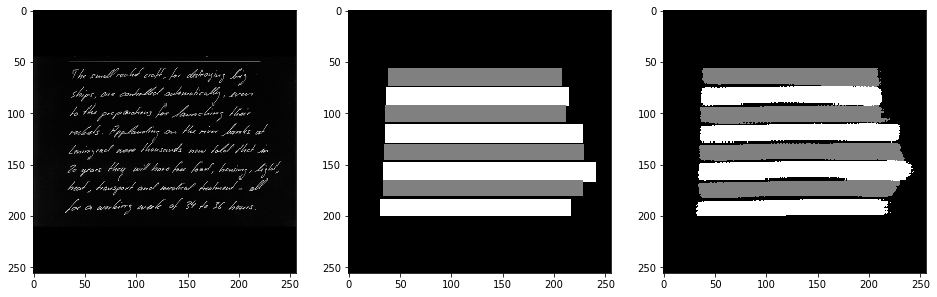

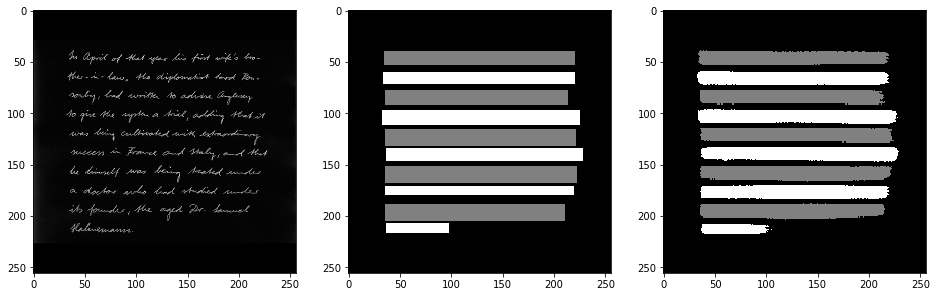

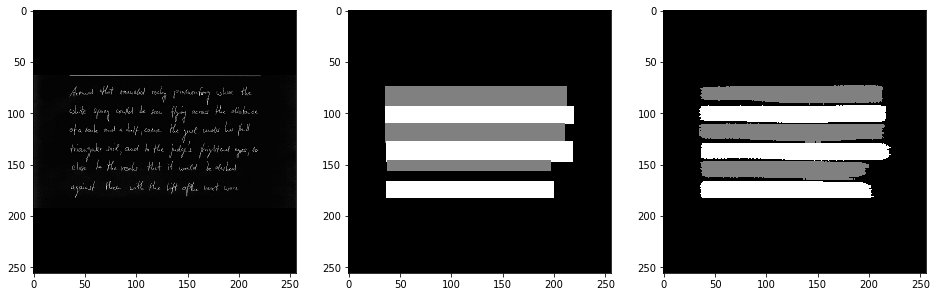

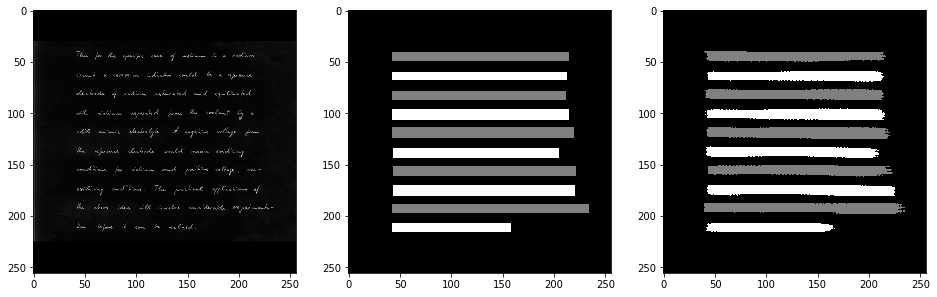

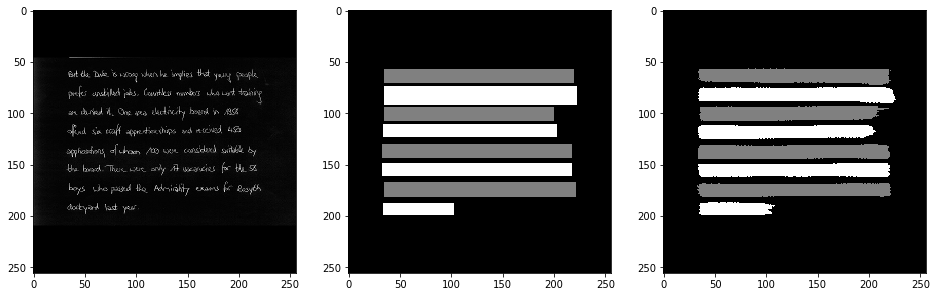

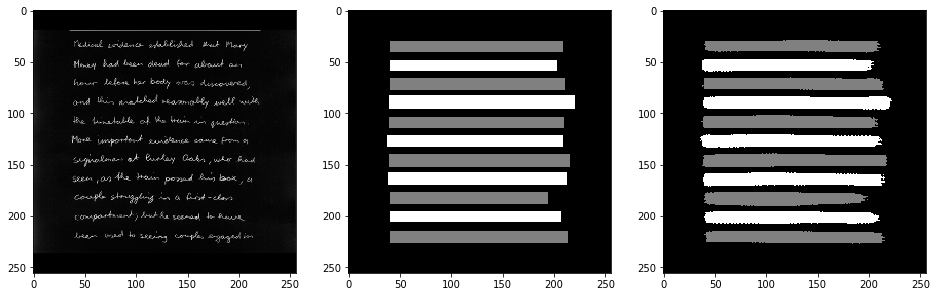

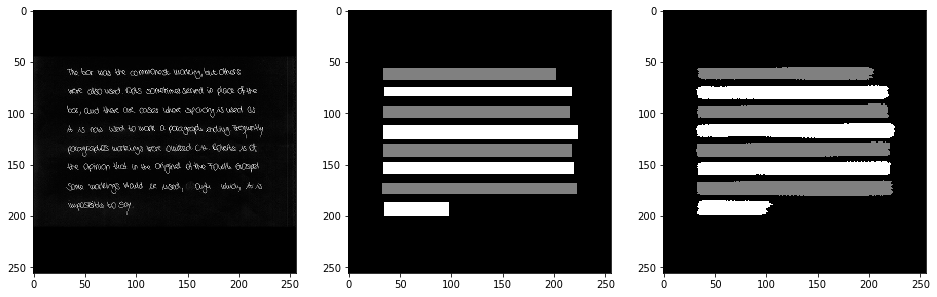

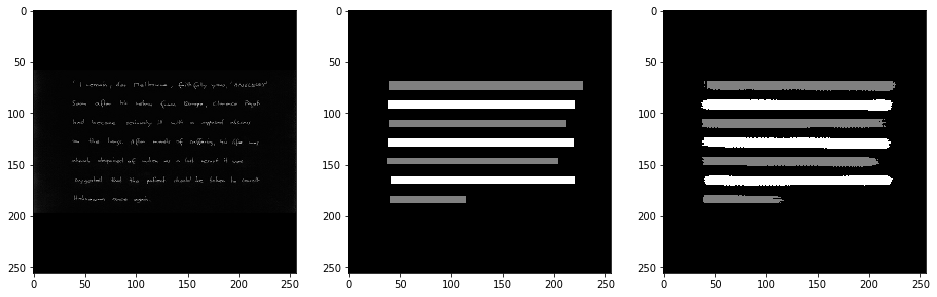

In [22]:
start_id = 0
count = 20

X = dataset.x_test[start_id:start_id+count]
Y = dataset.y_test[start_id:start_id+count]

Y_pred = model.predict(X)
for x, y, y_pred in zip(X, Y, Y_pred):
    hplot(x, np.argmax(y, axis=-1), np.argmax(y_pred, axis=-1))

In [27]:
class DatasetSequence:
    def __init__(self, augment_fn):
        self.augment_fn = augment_fn
    
    def getitem(self, a):
        return self.augment_fn(a)

class Model:
    def __init__(self, data):
        self.data = data
        
    def augment_fn(self, a):
        return a + self.data

In [29]:
model = Model(data=5)
model.augment_fn(15)

20

In [30]:
data = DatasetSequence(augment_fn=model.augment_fn)
data.getitem(15)

20

In [31]:
data.getitem(100)

105